<a href="https://colab.research.google.com/github/datascientist-hist/Spam_Messages_Classification/blob/main/Spam_Messages_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparing environment and dataset

In [115]:
! pip install plotly_express

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [116]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly_express as px
import plotly.figure_factory as ff
from wordcloud import WordCloud
import nltk
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [117]:
data=pd.read_csv('Spam_Classification.csv')

In [118]:
print(data.shape)
print(data.columns)

(5572, 2)
Index(['Category', 'Message'], dtype='object')


In [119]:
data.head(10)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [120]:
data['Category'].value_counts().to_dict()

{'ham': 4825, 'spam': 747}

In [121]:
fig = px.histogram(data, x="Category", color="Category",
                   color_discrete_sequence=['#003f5c', '#ffa600'])
fig.show()

In [122]:
data['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

The dataset is unbalanced, we can observe that there are:
- 560 observations as Spam
- 3619 observations as ham

#EDA
I am going to perform a cleaning of the dataset 


In [123]:
#apply len columns to entire dataset and for train and test dataset
data['length'] = data['Message'].apply(len)

In [124]:
data.head()

,Category,Message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Here we will observe if there are difference in length between email spam and not

In [125]:

lis=[data.length[data['Category']=='ham'], data.length[data['Category']=='spam']]
group_labels=['ham','spam']
colors = ['#003f5c', '#ffa600']
# Create distplot 
fig = ff.create_distplot(lis, group_labels, bin_size=20,show_rug=False,
                         curve_type='kde', # override default 'kde'
                         colors=colors)

# Add title
fig.update_layout(xaxis_range=[0,300])
fig.update_layout(title_text='Distplot with Normal Distribution')
fig.show()

In [126]:

mean_spam=data.length[data['Category']=='spam'].mean()
mean_ham=data.length[data['Category']=='ham'].mean()

sd_spam=data.length[data['Category']=='spam'].std()
sd_ham=data.length[data['Category']=='ham'].std()

print('the average length for spam is :',round(mean_spam,2),'with standard deviation :',sd_spam)
print('the average length for ham is :',round(mean_ham,2),'with standard deviation :',sd_ham)

the average length for spam is : 137.99 with standard deviation : 29.9802865150208
the average length for ham is : 71.45 with standard deviation : 58.4348642857575


#Feature Engineering

## Preprocess the data

In this step first i have to perform the following steps:
- convert tha label feature in numerical feature 
- convert web addresses
- convert  phone numbers
- convert  numbers 
-  encode symbols, 
- remove punctuation and white spaces
- convert all text to lowercase

In [127]:
data['class_label'] = data['Category'].map( {'spam': 1, 'ham': 0})

In [128]:
# Replace email address with 'emailaddress'

data['Message'] = data['Message'].str.replace(r"[\w.+-]+@[\w-]+\.[\w.-]+", '  em  ')

# Replace urls with 'webaddress'
data['Message'] = data['Message'].str.replace(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])', '  wb ')

# Replace money symbol with 'money-symbol'
data['Message'] = data['Message'].str.replace(r'£|\$', '  ms  ')

# Replace 10 digit phone number with 'phone-number'
data['Message'] = data['Message'].str.replace(r'(\d{3}\d{3}\d{4})', '  pn  ' )

# Replace normal number with 'number'
data['Message'] = data['Message'].str.replace(r'\d+(\.\d+)?', '  n  ')

# remove punctuation
data['Message'] = data['Message'].str.replace(r'[^\w\d\s]', ' ')

# remove whitespace between terms with single space
data['Message'] = data['Message'].str.replace(r'\s+', ' ')

# remove leading and trailing whitespace
data['Message'] = data['Message'].str.replace(r'^\s+|\s*?$', ' ')

# change words to lower case
data['Message'] = data['Message'].str.lower()

Going forward, we'll remove stopwords from the message content. Stop words are words that search engines have been programmed to ignore, such as “the”, “a”, “an”, “in”, "but", "because" etc.

In [129]:
data['Message'].iloc[0:10]

0    go until jurong point crazy available only in ...
1                            ok lar joking wif u oni  
2    free entry in n a wkly comp to win fa cup fina...
3        u dun say so early hor u c already then say  
4    nah i don t think he goes to usf he lives arou...
5    freemsg hey there darling it s been n week s n...
6    even my brother is not like to speak with me t...
7    as per your request melle melle oru minnaminun...
8    winner as a valued network customer you have b...
9    had your mobile n months or more u r entitled ...
Name: Message, dtype: object

In [130]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [131]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [132]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
data['Message'] = data['Message'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

Next, we will extract the base form of words by removing affixes from them. This called stemming,there are numerous stemming algorithms,i'll use Snowball Stemmer


<a href="https://ibb.co/RpqbT1p"><img src="https://i.ibb.co/nsFmMTs/stopword.png" alt="stopword" border="0"></a>

In [133]:
ss = nltk.SnowballStemmer("english")
data['Message'] = data['Message'].apply(lambda x: ' '.join(ss.stem(term) for term in x.split()))


## Count Vectors

Machine learning algorithms cannot work with raw text directly. The text must be converted into numbers.
First, we create a Bag of Words (BOW) model to extract features from text:

This algorithm is very similar to the one-hot encoding, but it has the advantage of identifying the frequency/counts of the words in the documents they appear.

- Step 1:Convert each document into a sequence of words containing that document.

- Step 2: From the set of all the words in the corpus, count how often the word occurs in the document.


In [134]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [135]:
from sklearn.feature_extraction.text import CountVectorizer

sms_df = data['Message']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sms_df)
#print(vectorizer.get_feature_names())


In [136]:

print(len(X.toarray()[0]))
count_words=pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
count_words['label']=data['class_label']
count_words.head()


6279


,____,aa,aah,aaniy,aaooooright,aathi,ab,abbey,abdomen,abeg,abel,aberdeen,abi,abil,abiola,abj,abl,abnorm,abouta,abroad,absenc,absolut,abstract,abt,abta,aburo,abus,ac,academ,acc,accent,accentur,accept,access,accid,accident,accommod,accommodationvouch,accomod,accord,accordin,account,accumul,ach,achan,achiev,acid,acknowledg,acl,acnt,...,ymca,yo,yoga,yogasana,yor,yorg,youdo,youi,young,younger,youphon,your,yourinclus,yourjob,youuuuu,youwanna,yovill,yowif,yoyyooo,yr,yrs,ystrday,yt,ything,yummi,yummmm,yun,yunni,yuo,yuou,yup,yupz,zac,zaher,zealand,zebra,zed,zero,zf,zhong,zindgi,zoe,zogtorius,zoom,zouk,zs,zyada,èn,〨ud,label
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [137]:
#Searching  the 100 most frequent words in spam emails

df_spam=count_words[count_words['label']==1].sum()
df_spam.sort_values(ascending=False,inplace=True)
df_spam.drop('label',inplace=True)
spam_words=df_spam.iloc[0:100]

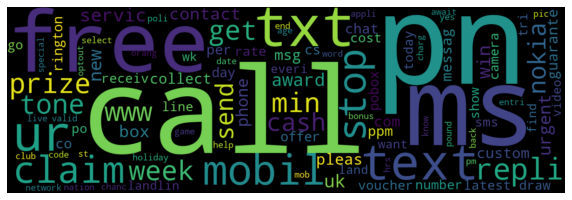

In [138]:
#Showing the  100 most used word in spam emails
wc = WordCloud(width=1200, height=400, max_words=200).generate_from_frequencies(spam_words.to_dict())

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [139]:
#Searching  the 100 most frequent words in ham emails

df_ham=count_words[count_words['label']==0].sum()
df_ham.sort_values(ascending=False,inplace=True)
df_ham.drop('label',inplace=True)
ham_words=df_ham.iloc[0:100]

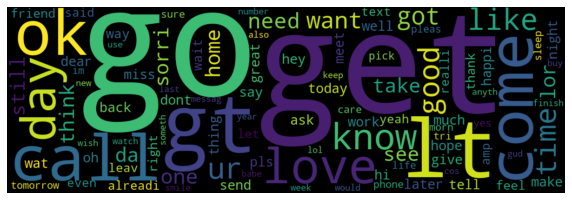

In [140]:
#Showing the  100 most used word in ham emails
wc = WordCloud(width=1200, height=400, max_words=200).generate_from_frequencies(ham_words.to_dict())

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

After that I searched the most used words for each category ,i will create a Bag of Word only with  that in order to reduce the number of variable that the model should  to handle

In [141]:
#columns to maintain
col= [*spam_words.index,*ham_words.index]
print(len(col))
#removing duplicate word
col = [*set(col)]
print(len(col))


200
181


In [142]:
#filtering columns from count_words dataframe
count_words=count_words[col]
count_words.shape


(5572, 181)

In [143]:
count_words['length']=data['length']
count_words['label']=data['class_label']

In [144]:
count_words.shape

(5572, 183)

# Splitting data

Since i will use K-fold cross validation i don't need to split dataset ,i need only:

- X dataset
- Y dataset

In [145]:
data.columns

Index(['Category', 'Message', 'length', 'class_label'], dtype='object')

In [146]:

Y=data['class_label']
X=count_words.drop('label',axis=1)


In [147]:
X.head()

,come,let,claim,ppm,cost,holiday,much,select,mobil,msg,charg,thing,word,home,week,messag,award,end,lt,one,hi,pls,repli,feel,tell,see,wk,stop,game,use,pick,optout,get,time,special,pn,code,way,realli,appli,morn,rington,new,win,hope,babe,yeah,ok,got,chanc,...,alreadi,per,sleep,phone,good,care,free,great,lol,tri,latest,hrs,oh,ask,later,valid,chat,await,text,poli,friend,age,offer,rate,like,smile,tomorrow,gud,receiv,txt,day,pic,show,pound,right,dear,thank,cs,find,send,draw,lor,last,wat,prize,co,well,keep,pobox,length
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,111
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,155
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61


# Model Building
I will use a series of model:

|Model|Accuracy Baseline|
|-----|--------|
|Naive Bayes| 87.83%|
|Logistic Regression| 97.02%|
|**Random Forest**| 98.22%| 
|Support Vector Classifier| 86.59%| 
|Voting Classifier |97.45%|





In [148]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [149]:
#I usually use Naive Bayes as a baseline for my classification tasks 
gnb = GaussianNB()
cv = cross_val_score(gnb,X,Y,cv=5)
print(cv)
print(cv.mean())

[0.94977578 0.95874439 0.96050269 0.95601436 0.95870736]
0.9567489191778507


In [150]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X,Y,cv=5)
print(cv)
print(cv.mean())

[0.98206278 0.98744395 0.97845601 0.98025135 0.98473968]
0.9825907528318748


In [151]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X,Y,cv=5)
print(cv)
print(cv.mean())

[0.98206278 0.9838565  0.98204668 0.97666068 0.98204668]
0.9813346644017036


In [152]:
svc = SVC()
cv = cross_val_score(svc,X,Y,cv=5)
print(cv)
print(cv.mean())

[0.86547085 0.86547085 0.86624776 0.86624776 0.86624776]
0.8659369943080726


In [153]:
#Voting classifier takes all of the inputs and averages the results. For a "hard" voting classifier each classifier gets 1 vote "yes" or "no" and the result is just a popular vote. For this, you generally want odd numbers
#A "soft" classifier averages the confidence of each of the models. If a the average confidence is > 50% that it is a 1 it will be counted as such
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr',lr),('rf',rf),('svc',svc)], voting = 'hard') 
cv = cross_val_score(voting_clf,X,Y,cv=5)
print(cv)
print(cv.mean())


[0.9793722  0.98475336 0.97845601 0.97576302 0.98563734]
0.9807963867934403


At this point before moving on we should choose the model to tune,in
this case i will take into account only the accuracy to choose the model (but we could consider 'recall','precision' and other),for this reason i will choose 
**random forest**


# Tuning the model

Tuning Random Forest classifier

In [154]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [155]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [156]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [500],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25],
                                  'max_features': ['sqrt'],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X,Y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [157]:
clf_performance(best_clf_rf,'Random Forest')

Random Forest
Best Score: 0.9782835658677573
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


In [158]:
best_rf = best_clf_rf.best_estimator_.fit(X,Y)

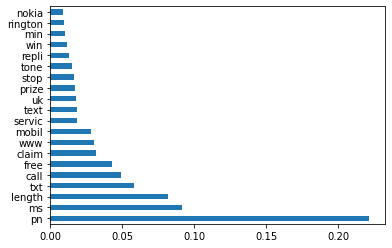

In [159]:
feat_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Saving model with pickle

Pickle is the standard way of serializing objects in Python.

We can use the pickle operation to serialize our machine learning algorithms and save the serialized format to a file.

In [160]:
import pickle

In [161]:
# save the model (98.20 % accuracy) to disk
filename = 'spam_classifier_model.sav'
pickle.dump(best_rf, open(filename, 'wb'))


In [162]:
#save also the columns useful for the data
col=X.columns
with open('columns.sav', 'wb') as f:    #Pickling
     pickle.dump(col, f)

In [163]:
with open("columns.sav", "rb") as fp:   #Unpickling
    cl = pickle.load(fp)


In [164]:
'''
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result) 
'''

"\n# load the model from disk\nloaded_model = pickle.load(open(filename, 'rb'))\nresult = loaded_model.score(X_test, Y_test)\nprint(result) \n"

# Deploying model

With this step i want to enclose the code to use the model
- We will ask to the user to provide an email to classify
- The we will perform a cleaning of the text
- we will use a bag of word created before
- then we will count the frequency
- at the end we will predict the class of the email :
 - 1 spam
 - 0 ham

## Entering text

In [165]:
#email=input("Enter your email to classify if it is spam or not: ")
email='Hello my name is Giuseppe and i am glad to meet you'

# Cleaning text

In [166]:
data=pd.DataFrame(data={"Message":[email]})

In [167]:
# Replace email address with 'emailaddress'

data['Message'] = data['Message'].str.replace(r"[\w.+-]+@[\w-]+\.[\w.-]+", '  em  ')

# Replace urls with 'webaddress'
data['Message'] = data['Message'].str.replace(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])', '  wb ')

# Replace money symbol with 'money-symbol'
data['Message'] = data['Message'].str.replace(r'£|\$', '  ms  ')

# Replace 10 digit phone number with 'phone-number'
data['Message'] = data['Message'].str.replace(r'(\d{3}\d{3}\d{4})', '  pn  ' )

# Replace normal number with 'number'
data['Message'] = data['Message'].str.replace(r'\d+(\.\d+)?', '  n  ')

# remove punctuation
data['Message'] = data['Message'].str.replace(r'[^\w\d\s]', ' ')

# remove whitespace between terms with single space
data['Message'] = data['Message'].str.replace(r'\s+', ' ')

# remove leading and trailing whitespace
data['Message'] = data['Message'].str.replace(r'^\s+|\s*?$', ' ')

# change words to lower case
data['Message'] = data['Message'].str.lower()

In [168]:
data.head()

,Message
0,hello my name is giuseppe and i am glad to mee...


In [169]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [170]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
data['Message'] = data['Message'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [171]:
ss = nltk.SnowballStemmer("english")
data['Message'] = data['Message'].apply(lambda x: ' '.join(ss.stem(term) for term in x.split()))

In [172]:
data.head()

,Message
0,hello name giusepp glad meet


## Preparing dataset to be provided to the model

In [173]:
#Loading columns for model and create dataframe for the model
cl = pickle.load(open('columns.sav', 'rb'))
newdata = pd.DataFrame(0, index=np.arange(len(data)), columns=cl)
print(newdata.shape)
newdata.head()

(1, 182)


,come,let,claim,ppm,cost,holiday,much,select,mobil,msg,charg,thing,word,home,week,messag,award,end,lt,one,hi,pls,repli,feel,tell,see,wk,stop,game,use,pick,optout,get,time,special,pn,code,way,realli,appli,morn,rington,new,win,hope,babe,yeah,ok,got,chanc,...,alreadi,per,sleep,phone,good,care,free,great,lol,tri,latest,hrs,oh,ask,later,valid,chat,await,text,poli,friend,age,offer,rate,like,smile,tomorrow,gud,receiv,txt,day,pic,show,pound,right,dear,thank,cs,find,send,draw,lor,last,wat,prize,co,well,keep,pobox,length
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Preparing dataset from the text useful to update dataset for the model

In [174]:
#create dataframe from the text in input
from sklearn.feature_extraction.text import CountVectorizer

sms_df = data['Message']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sms_df)
#print(vectorizer.get_feature_names())



In [175]:
print(len(X.toarray()[0]))
count_words=pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
count_words['length']=len(email)
count_words.head()

5


,giusepp,glad,hello,meet,name,length
0,1,1,1,1,1,51


##  Updating dataset to be provided to the model

In [176]:
#now i will overlap dataframe from text with dataframe for the model
newdata.update(count_words)
pd.set_option('display.max_columns', 100)
newdata.head() 


,come,let,claim,ppm,cost,holiday,much,select,mobil,msg,charg,thing,word,home,week,messag,award,end,lt,one,hi,pls,repli,feel,tell,see,wk,stop,game,use,pick,optout,get,time,special,pn,code,way,realli,appli,morn,rington,new,win,hope,babe,yeah,ok,got,chanc,...,alreadi,per,sleep,phone,good,care,free,great,lol,tri,latest,hrs,oh,ask,later,valid,chat,await,text,poli,friend,age,offer,rate,like,smile,tomorrow,gud,receiv,txt,day,pic,show,pound,right,dear,thank,cs,find,send,draw,lor,last,wat,prize,co,well,keep,pobox,length
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51


## Loading model

In [177]:
#Loading model saved
rfc = pickle.load(open('spam_classifier_model.sav', 'rb'))
#result = rfc.score(X, Y)
print(result) 

0.9874371859296482


## Classifying email

In [178]:
prediction = rfc.predict(newdata)
if(prediction ==1): print("spam")
else: print('ham')

ham
